# 1 setup


## 1.1 install dependencies

In [1]:
!python --version


Python 3.9.13


In [2]:
!pip install tensorflow==2.5.0 tensorflow-gpu==2.5.0 opencv-python matplotlib



In [3]:
!pip install matplotlib


In [4]:
# import  standard dependencies
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt


In [5]:

pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [6]:
#plt.imshow??

In [7]:
 #import tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D ,Dense,MaxPooling2D,Input,Flatten
import tensorflow as tf

In [8]:
#MOdel(input=[inputimage,verificationimage],output=[1,0])

In [9]:
# class L1Dist(layer)

## 1.3 setup GPU Growth

In [10]:
#avoid OOM errors by setting GPU memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [11]:
 # setup paths
POS_PATH= os.path.join('data','positive')
NEG_PATH= os.path.join('data','negative')
ANC_PATH= os.path.join('data','anchor')

In [12]:
# make the directories
os.makedirs=(POS_PATH)
os.makedirs=(NEG_PATH)
os.makedirs=(ANC_PATH)

In [13]:
#https://vis-www.cs.umass.edu/Lfw/

In [14]:
#uncompress tar GZ Labelled Faces in the Wild Dataset
!tar -xf lfw.tgz  

In [15]:
#move the LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_path= os.path.join('lfw',directory,file)
        NEW_path =os.path.join(NEG_PATH,file)
        os.replace(EX_path,NEW_path)

In [16]:
#for directory in os.listdir('lfw'):
#   for file in os.listdir(os.path.join('lfw',directory)):
#        print(os.path.join('lfw',directory,file))
#        print(os.path.join(NEG_PATH,file))
    

In [17]:
#import uuid library to generate unique image name
import uuid


In [18]:
uuid.uuid1()


UUID('dd2caff0-8088-11ef-903f-e070eaadadb4')

In [19]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1367: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvWaitKey'


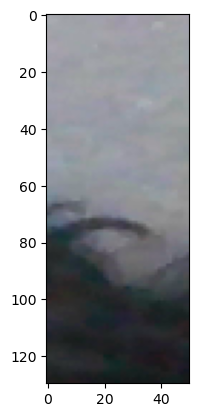

In [21]:
plt.imshow(frame[120:120+250,200:200+250,:])

In [22]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*jpg').take(300)

In [23]:
ANC_PATH+'\*jpg'

'data\\anchor\\*jpg'

In [24]:
dir_test=anchor.as_numpy_iterator()

In [25]:
print(dir_test.next())

b'data\\anchor\\ef55a990-6115-11ef-abd1-e070eaadadb4.jpg'


In [26]:
def preprocess(file_path):
    
    #read in image fron file path
    byte_img = tf.io.read_file(file_path)
    #load in the image
    img = tf.io.decode_jpeg(byte_img)
    
    #preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img,(100,100))
    #scaling image to be between 0 and 1
    img = img/255.0
    #return image
    return img

In [27]:
img = preprocess('data\\anchor\\ed272b33-6115-11ef-821e-e070eaadadb4.jpg')

In [28]:
img.numpy().max()

0.8781863

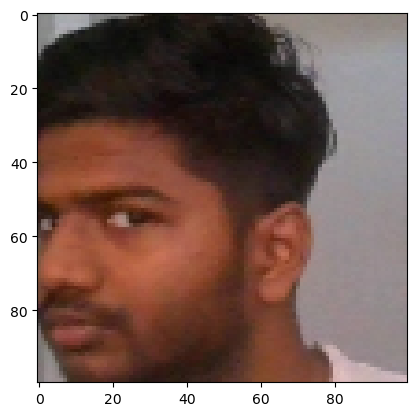

In [29]:
plt.imshow(img)

In [30]:
#dataset.map(preprocess)

In [31]:
#(anchor,positive)==1,1,1,1,1
#(anchor,negative)==0,0,0,0,0


tf.ones_like([1,1,1,4.76576,2352.5])

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 1., 1., 1., 1.], dtype=float32)>

In [32]:
class_labels = tf.data.Dataset.from_tensor_slices( tf.zeros(len(anchor)))

In [33]:
#iterator_labs.next()



#iterator_labs = class_labels.as_numpy_iterator()

In [34]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data= positives.concatenate(negatives)

In [35]:
samples= data.as_numpy_iterator()

In [36]:
example = samples.next()

In [37]:
def preprocess_twin(input_img,validation_img, label):
    return(preprocess(input_img),preprocess(validation_img),label)

In [38]:
res= preprocess_twin(*example)

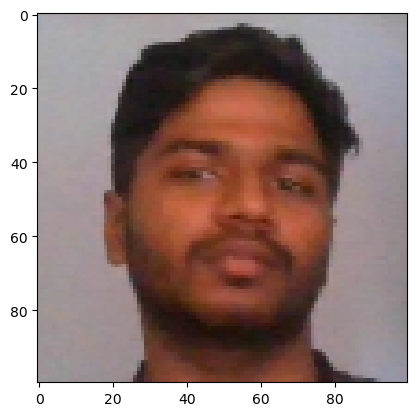

In [39]:
plt.imshow(res[1])

In [40]:
res[2]

1.0

In [41]:
# build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [42]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [43]:
#training partition
train_data= data.take(round(len(data)*.7))
train_data=train_data.batch(16)
train_data=train_data.prefetch(8)

In [44]:
train_samples = train_data.as_numpy_iterator()

In [45]:
train_samples=train_samples.next()

In [46]:
len(train_samples[0])

16

In [47]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data= test_data.batch(16)
test_data= test_data.prefetch(8)

In [48]:
inp=Input(shape=(100,100,3),name='input_image')

In [49]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [50]:
#first block
c1 = Conv2D(64,(10,10),activation='relu')(inp)

m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [51]:
#second block
c2 = Conv2D(128,(7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)


In [52]:
#third block
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [53]:
#final embedding block
c4 = Conv2D(256, (4,4), activation='relu')(m2)
f1= Flatten()(c4)
d1 = Dense(4096,activation='sigmoid')(f1)

In [54]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [55]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 17, 17, 256)       524544    
_________________________________________________________________
flatten (Flatten)            (None, 73984)             0 

In [56]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [57]:
embedding = make_embedding()

In [58]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [59]:
#siamese L1 Distance class
#class L1Dist(Layer):
 #   def __init__(self,**kwargs):
 #       super().__init__()
       #magic happens here 
 #   def call(self,input_embedding, validation_embedding):
  #      return tf.math.abs(input_embedding - validation_embedding)
    
   # Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding) 

In [60]:
l1= L1Dist()

In [61]:
#l1(anchor_embedding, validation_embedding)

In [62]:
input_image=Input(name='input_img',shape=(100,100,3))
validation_image =Input(name='validation_img',shape=(100,100,3))

In [63]:
inp_embedding =embedding(input_image)
val_embedding =embedding(validation_image)

In [64]:
siamese_layer =L1Dist()

In [65]:
distances = siamese_layer(inp_embedding, val_embedding)

In [66]:
classifier = Dense(1, activation='sigmoid')(distances)

In [67]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [68]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [69]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [70]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [71]:
siamese_model = make_siamese_model()

In [72]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

In [73]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [74]:
opt = tf.keras.optimizers.Adam(1e-4) #0.001

In [75]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [76]:
test_batch = train_data.as_numpy_iterator()


In [77]:
batch_1 = test_batch.next()

In [78]:
x= batch_1[:2]

In [79]:
y = batch_1[2]

In [80]:
y

array([1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1.],
      dtype=float32)

In [81]:
#tf.losses.BinaryCrossentropy??

In [82]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [83]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [85]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        #r = Recall()
        #p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            #loss = train_step(batch)
           # yhat = siamese_model.predict(batch[:2])
           # r.update_state(batch[2], yhat)
           # p.update_state(batch[2], yhat) 
            train_step(batch)
            progbar.update(idx+1)
       # print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [86]:
EPOCHS = 10

In [87]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
 1/27 [>.............................] - ETA: 6:28

KeyboardInterrupt: 

In [88]:
#import metric calculation
from tensorflow.keras.metrics import Precision,Recall

In [89]:
#get a batch of test data 
test_input, test_val,y_true = test_data.as_numpy_iterator().next()

In [90]:
#test_var= test_data.as_numpy_iterator().next()

In [91]:
#make prediction
y_hat= siamese_model.predict([test_input,test_val])
y_hat

array([[0.3431825 ],
       [0.4842133 ],
       [0.39801115],
       [0.49597824],
       [0.49932173],
       [0.38859642],
       [0.49969357],
       [0.3581227 ],
       [0.49878007],
       [0.3694533 ],
       [0.50038576],
       [0.4939282 ],
       [0.3675391 ],
       [0.47201505],
       [0.49878532],
       [0.39362735]], dtype=float32)

In [92]:
# post processing  the results
[1 if predictions>0.5 else 0 for predictions in y_hat]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

In [93]:
y_true

array([0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.],
      dtype=float32)

In [94]:
#creating a metric object
m=Recall()

#calculating the recall value
m.update_state(y_true,y_hat)

# return Recall Result
m.result().numpy()

0.11111111

 ## 6.4 viz results

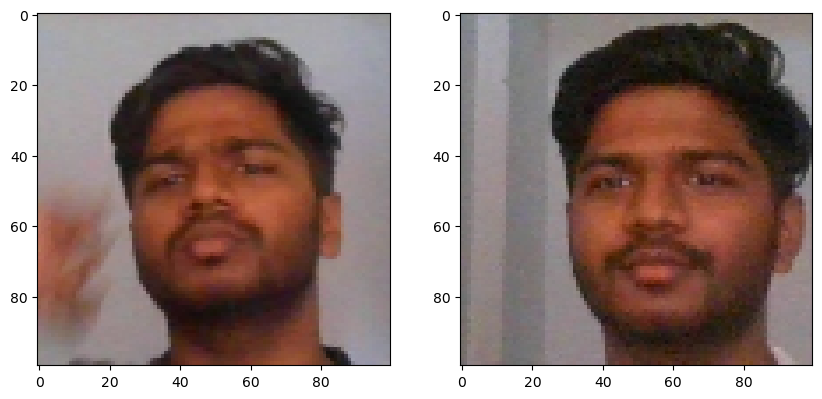

In [95]:
#set plot  size
plt.figure(figsize=(10,8))
# set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[1])

#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[1])

#render cleanly
plt.show()


#  7. save model

In [96]:
# save weights
siamese_model.save('siamesemodelv2.h5')

In [97]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [98]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])


array([[0.3431825 ],
       [0.4842133 ],
       [0.39801115],
       [0.49597824],
       [0.49932173],
       [0.38859642],
       [0.49969357],
       [0.3581227 ],
       [0.49878007],
       [0.3694533 ],
       [0.50038576],
       [0.4939282 ],
       [0.3675391 ],
       [0.47201505],
       [0.49878532],
       [0.39362735]], dtype=float32)

In [99]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_3 (L1Dist)              (None, 4096)         0           embedding[0][0]     

# 8. real time test

## 8.1 verification function

In [100]:
os.listdir(os.path.join('application_data', 'verification_images'))

['569fe7cf-6116-11ef-b4d2-e070eaadadb4.jpg',
 '5d3fb374-6116-11ef-a7a5-e070eaadadb4 - Copy - Copy.jpg',
 '5fc0a423-6116-11ef-9b49-e070eaadadb4 - Copy.jpg',
 '759ab159-6132-11ef-a6bd-e070eaadadb4.jpg',
 '83f9cbd3-6132-11ef-940e-e070eaadadb4.jpg',
 'a35e9df3-6132-11ef-b83a-e070eaadadb4.jpg',
 'a66ec520-6132-11ef-9e93-e070eaadadb4.jpg',
 'a71da1a9-6132-11ef-afb2-e070eaadadb4.jpg',
 'a7b914cf-6132-11ef-b1a3-e070eaadadb4.jpg',
 'a83fb886-6132-11ef-8452-e070eaadadb4.jpg',
 'a8cd41e7-6132-11ef-bea2-e070eaadadb4.jpg',
 'a9ae0f8d-6132-11ef-abc3-e070eaadadb4.jpg',
 'b04a6419-6131-11ef-8303-e070eaadadb4.jpg',
 'b1a46ea7-6132-11ef-9d00-e070eaadadb4.jpg',
 'b1ee8b57-6132-11ef-8825-e070eaadadb4.jpg',
 'b2ab9607-6131-11ef-a56f-e070eaadadb4.jpg',
 'b439ea4a-6132-11ef-a2cb-e070eaadadb4.jpg',
 'b51a9511-6132-11ef-b5f8-e070eaadadb4.jpg',
 'b6581552-6132-11ef-b0ae-e070eaadadb4.jpg',
 'b6bc1be4-6132-11ef-a6ef-e070eaadadb4.jpg',
 'b7626860-6132-11ef-83e2-e070eaadadb4.jpg',
 'b79cfc94-6132-11ef-9ebb-e070eaad

In [101]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [102]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\569fe7cf-6116-11ef-b4d2-e070eaadadb4.jpg
application_data\verification_images\5d3fb374-6116-11ef-a7a5-e070eaadadb4 - Copy - Copy.jpg
application_data\verification_images\5fc0a423-6116-11ef-9b49-e070eaadadb4 - Copy.jpg
application_data\verification_images\759ab159-6132-11ef-a6bd-e070eaadadb4.jpg
application_data\verification_images\83f9cbd3-6132-11ef-940e-e070eaadadb4.jpg
application_data\verification_images\a35e9df3-6132-11ef-b83a-e070eaadadb4.jpg
application_data\verification_images\a66ec520-6132-11ef-9e93-e070eaadadb4.jpg
application_data\verification_images\a71da1a9-6132-11ef-afb2-e070eaadadb4.jpg
application_data\verification_images\a7b914cf-6132-11ef-b1a3-e070eaadadb4.jpg
application_data\verification_images\a83fb886-6132-11ef-8452-e070eaadadb4.jpg
application_data\verification_images\a8cd41e7-6132-11ef-bea2-e070eaadadb4.jpg
application_data\verification_images\a9ae0f8d-6132-11ef-abc3-e070eaadadb4.jpg
application_data\verification_images\b04a64

In [103]:
def verify( model,detection_threshold,verification_threshold):
    #built result array
    results=[]
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_images = preprocess(os.path.join('application_data','input_images','input_images.jpg'))
        validation_images = preprocess(os.path.join('application_data','verification_images',image))

        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_images, validation_images], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 opencv real time verification

In [104]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_images', 'input_images.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.9, 0.9)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [ ]:
#cv2.waitKey??